# Customer churn in telecommunication
Churn means a customer used to spend a company but no longer do so. Analyzing customer churn is vital as it directly impacts revenue and a company's long-term sustainability. Understanding the reasons behind churn and implementing effective retention strategies is crucial in this competitive landscape, ensuring telecom companies can thrive and maintain their customer base.



## Data dictionary
- Target: Churn (customers who left within last month)
- Indepedent variables:
     1. Demographics: gender, senior citizen, partner, dependents   
     2. Services that customers have signed up for: phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
     3. Customer account information: tenure, contract, payment method, paperless billing, monthly charges, total charges
- Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

## Setup
I used VS Code to take advantage of its workplace function, so I can use relative path instead of absolute path in my analysis, which makes this data science more portable. You can follow the documentation from VS code to set up the environment [here ](https://code.visualstudio.com/docs/datascience/data-science-tutorial).

After setting up the environment, you can install more libraries to your environment doing the following:
1. Go to Miniconda prompt
2. Type 'conda activate <name_of_your_environment>' (Package will be installed in a contained environment so that it won't mess up with other projects)
3. Type 'conda install <package_name>'

Import libraries in VS code.   

In [48]:
# organization
import os

# data manupilation & visaulziation for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# handle imbalanced classifcation
# PS: need sklearn version 1.2.2 to avoid error, 1.3.0 got error; install with command 'conda install imbalanced-learn'
import imblearn            
from collections import Counter
from imblearn.over_sampling import SMOTE  # oversampling
from imblearn.pipeline import Pipeline

# modelling
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# folder
folder_input = '02_input'

Show the version of packages used in this notebook, so that others can replicate the package versions to avoid from running into error.

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.24.3
seaborn==0.12.2
imblearn==0.10.1


Import data

In [5]:
org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))
org.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


You could use [data wrangler extension](https://devblogs.microsoft.com/python/data-wrangler-release/) from VS Code to do basic data exploration, which could save a lot of time. For demonstration purpose, I continue to explore the data through the traditional coding way first.

In [6]:
org.shape


(7043, 21)

In [7]:
org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
# any missing values
org.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# unique value of categorical data
# check all unique value
colnames = org.select_dtypes(include=['object']).columns

for i in colnames:
    print(i, ": ", org[i].unique())

customerID :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender :  ['Female' 'Male']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges :  ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn :  ['No' 'Yes']


Total Charges should be numerical data. But I got an error when attempting to change it from object to numeric, because a few of its value is ' ' instead of 0 when customers have 0 tenure. CustomerID also doesn't seem to have much information, so let's delete it too.

In [10]:
# customer id
org = org.drop('customerID', axis=1)    # 1 = column, 0 = row

# total charges: change from " " to 0
org['TotalCharges'] = org['TotalCharges'].str.replace(" ", "0", case=False, regex=False)
org = org.astype({'TotalCharges': 'float64'})

## Exploratory data analysis (EDA)

Let's explore the target variable first. Only one forth of customers are churned, meaning this is an imbalanced binary classification problem.

In [11]:
cnt = org.Churn.value_counts()
print('Count of Churn \n', cnt, '\n')

cnt_perent = cnt/org.shape[0] * 100
print('Percentage of Churn \n', cnt_perent)


Count of Churn 
 Churn
No     5174
Yes    1869
Name: count, dtype: int64 

Percentage of Churn 
 Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


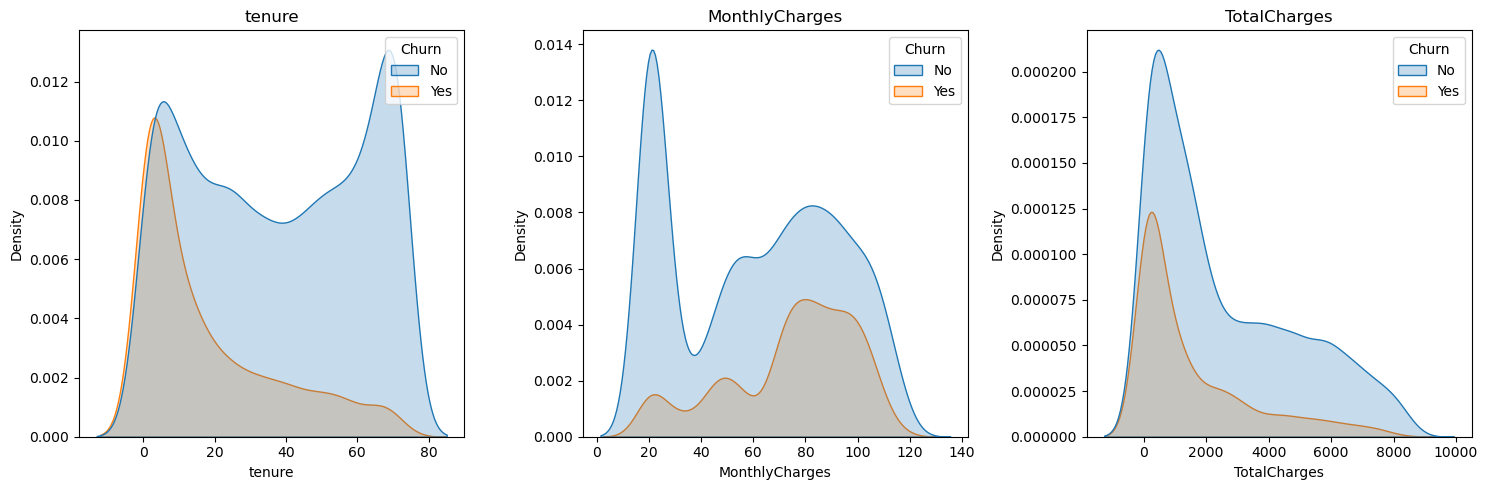

In [12]:
# numerical
def plot_numerical(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i, variable in enumerate(variables):
        ax = axes[i]
        sns.kdeplot(data=org, x=variable, hue='Churn', fill=True, ax=ax)
        ax.set_title(variable)

    plt.tight_layout()
    plt.show()


# plot
var_num = ['tenure', 'MonthlyCharges', 'TotalCharges']
plot_numerical(var_num, 1, 3 ,5)

Relationship between tenure, monthly charges and total charges

c:\Users\Lavinia\.conda\envs\myenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


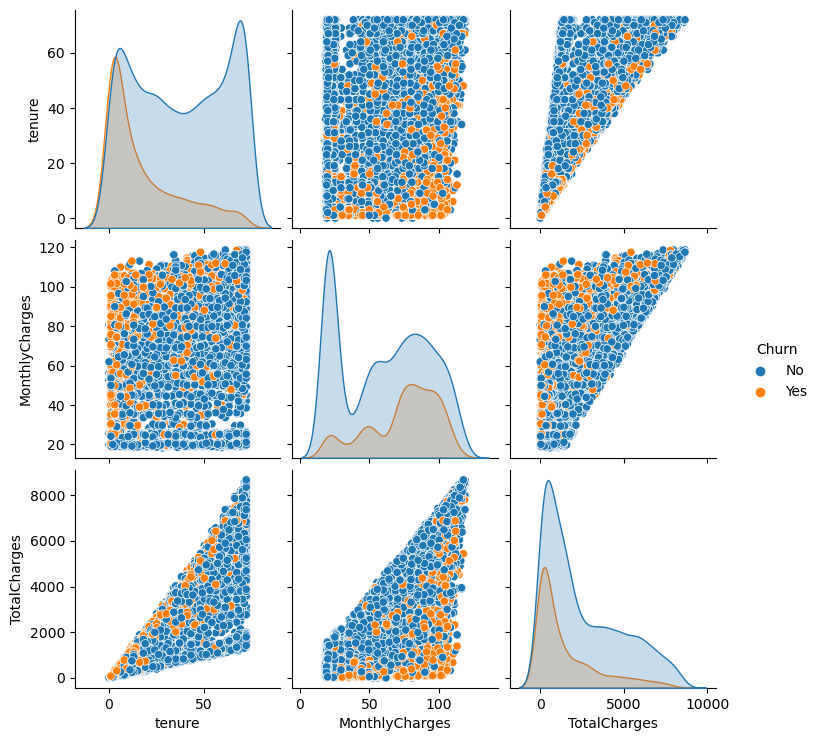

In [13]:
sns.pairplot(org[var_num + ['Churn']], hue='Churn')

In [14]:
# check if their monthly charge ever changed

org['Tenure_Calculated'] = org['TotalCharges']/org['MonthlyCharges'] - org['tenure']

# confirm it's different
print('Distribution of the difference between the tenure column and the calculated tenure')
print(org['Tenure_Calculated'].describe())

# # visulization
# sns.kdeplot(data=check, x='Tenure_calculated', hue='Churn', fill=True)
# plt.title('Distribution of difference between tenure column and the calculated tenure')

# indicate contract change
org['Is_MonthlyCharges_Changed'] = ((org['Tenure_Calculated'] < -0.5) | (org['Tenure_Calculated'] > 0.5)).astype('int')


Distribution of the difference between the tenure column and the calculated tenure
count    7043.000000
mean        0.002282
std         1.135584
min        -6.941748
25%        -0.517380
50%         0.000000
75%         0.488900
max         7.706941
Name: Tenure_Calculated, dtype: float64


### Demographics 

In [32]:
# function to plot data for EDA

# categorical
def plot_category(variables, nrow, ncol, size, rotation):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()        # cannot go to the second row of fig without this
    
    for i, variable in enumerate(variables):
        ax = sns.countplot(data=org, x=variable, hue='Churn', ax=axes[i])
        # plt.xticks(rotation=rotation)
        
        # Calculate percentages and annotate
        total = len(org)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.15
            y = p.get_height() + 10
            ax.annotate(percentage, (x, y), fontsize=10)
          
        
        ax.set_title(variable)
        ax.tick_params(axis='x', rotation=rotation)

    plt.tight_layout()
    plt.show()




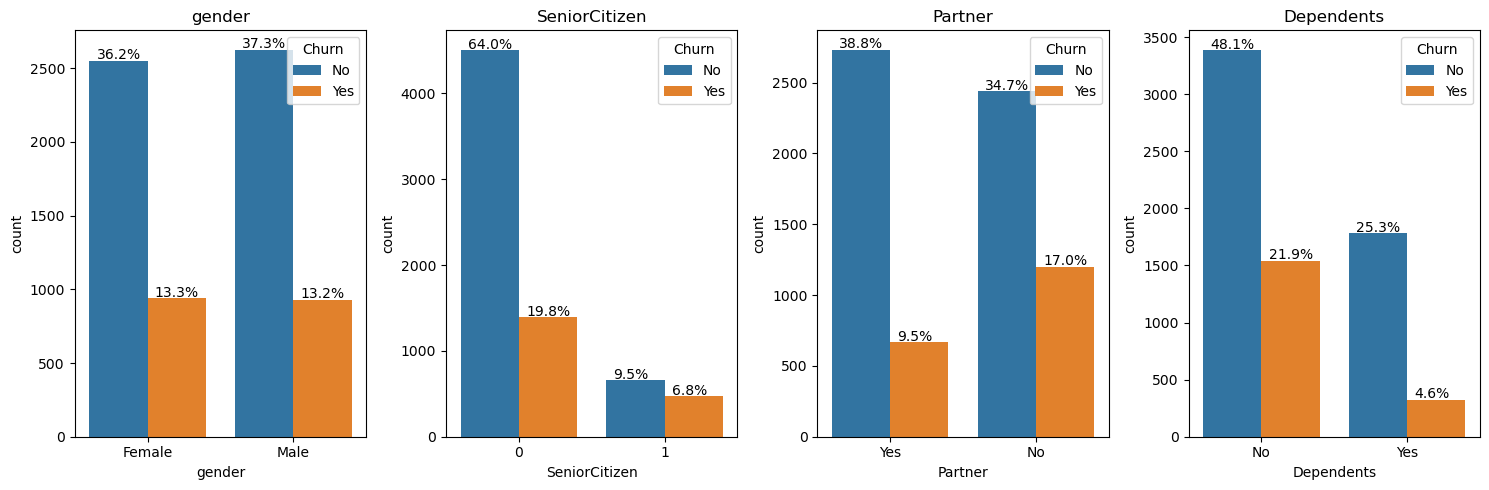

In [33]:
var_demo = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_category(var_demo, 1, 4, 5, 0)


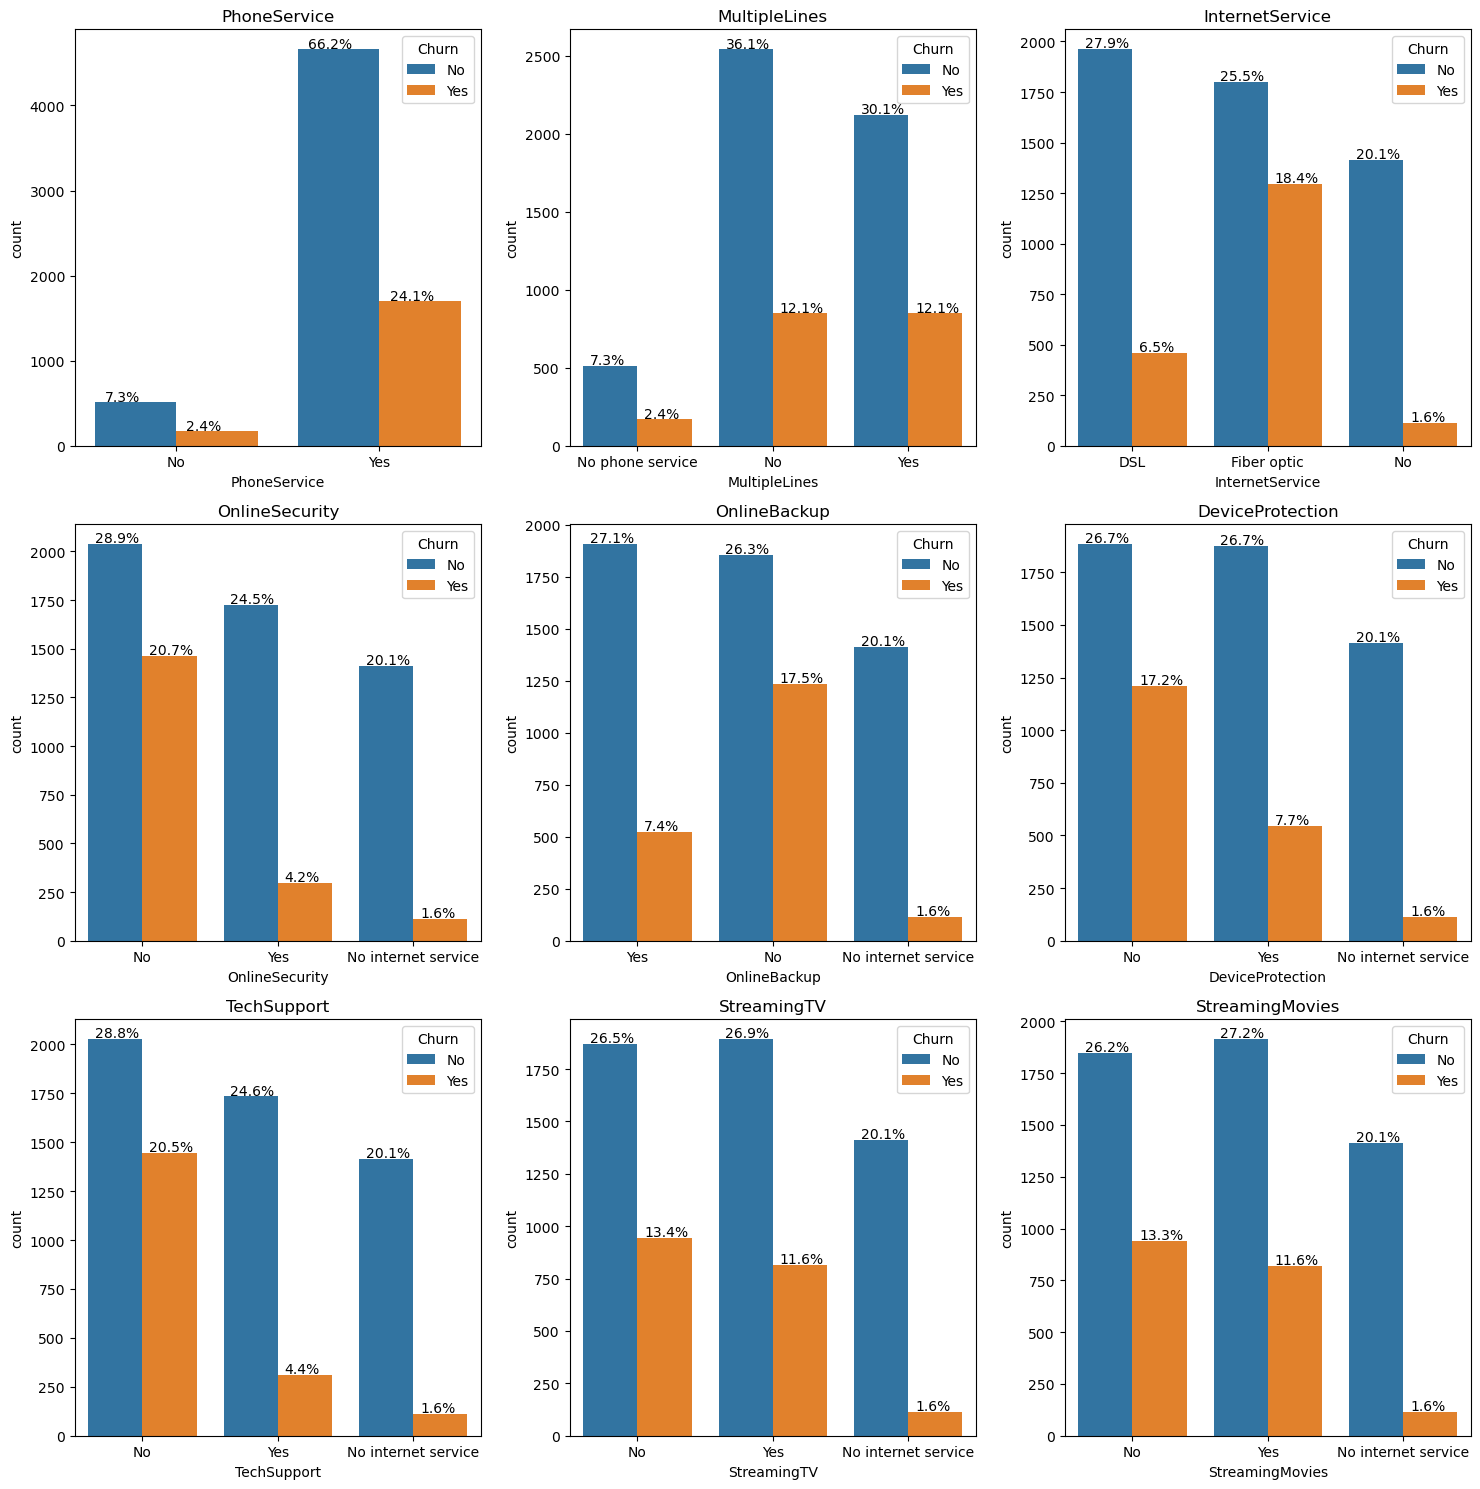

In [41]:
var_service = [
    'PhoneService', 
    'MultipleLines', 
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies'
    ]

plot_category(var_service, 3, 3, 15, 0)

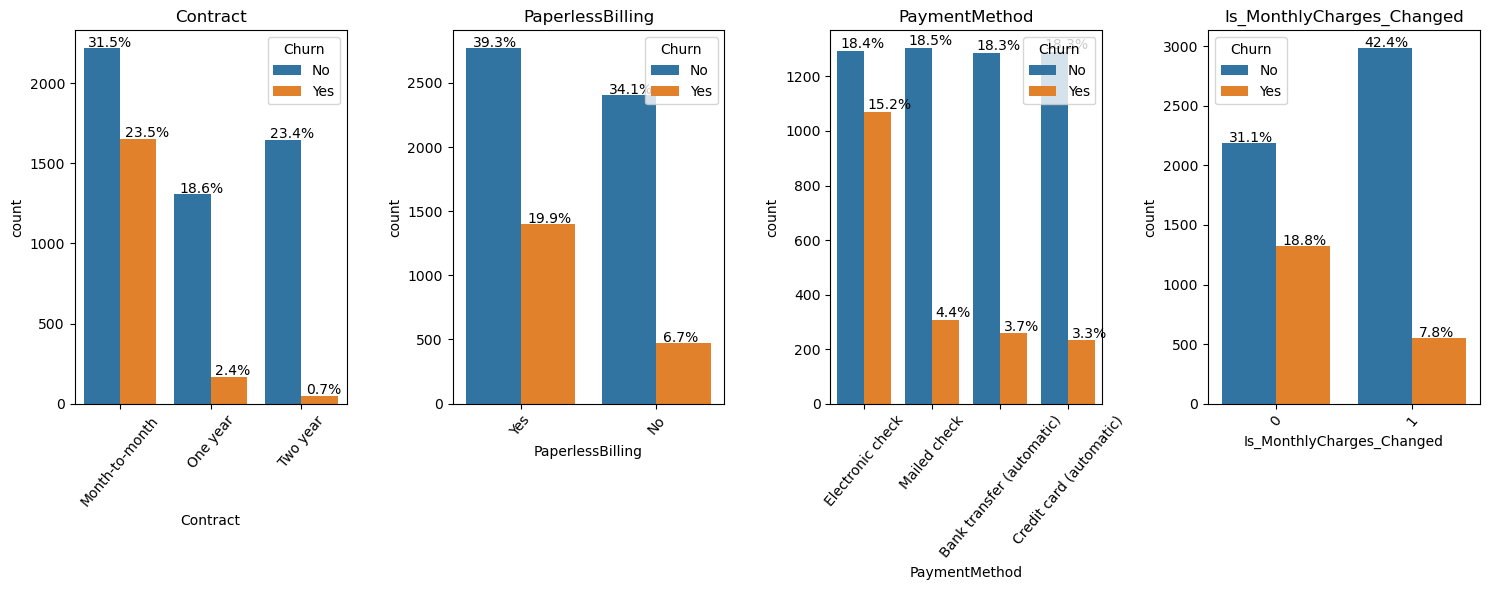

In [39]:
var_account_cat = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_MonthlyCharges_Changed']
plot_category(var_account_cat, 1, 4, 6, 50)

Monthly Charges vs services

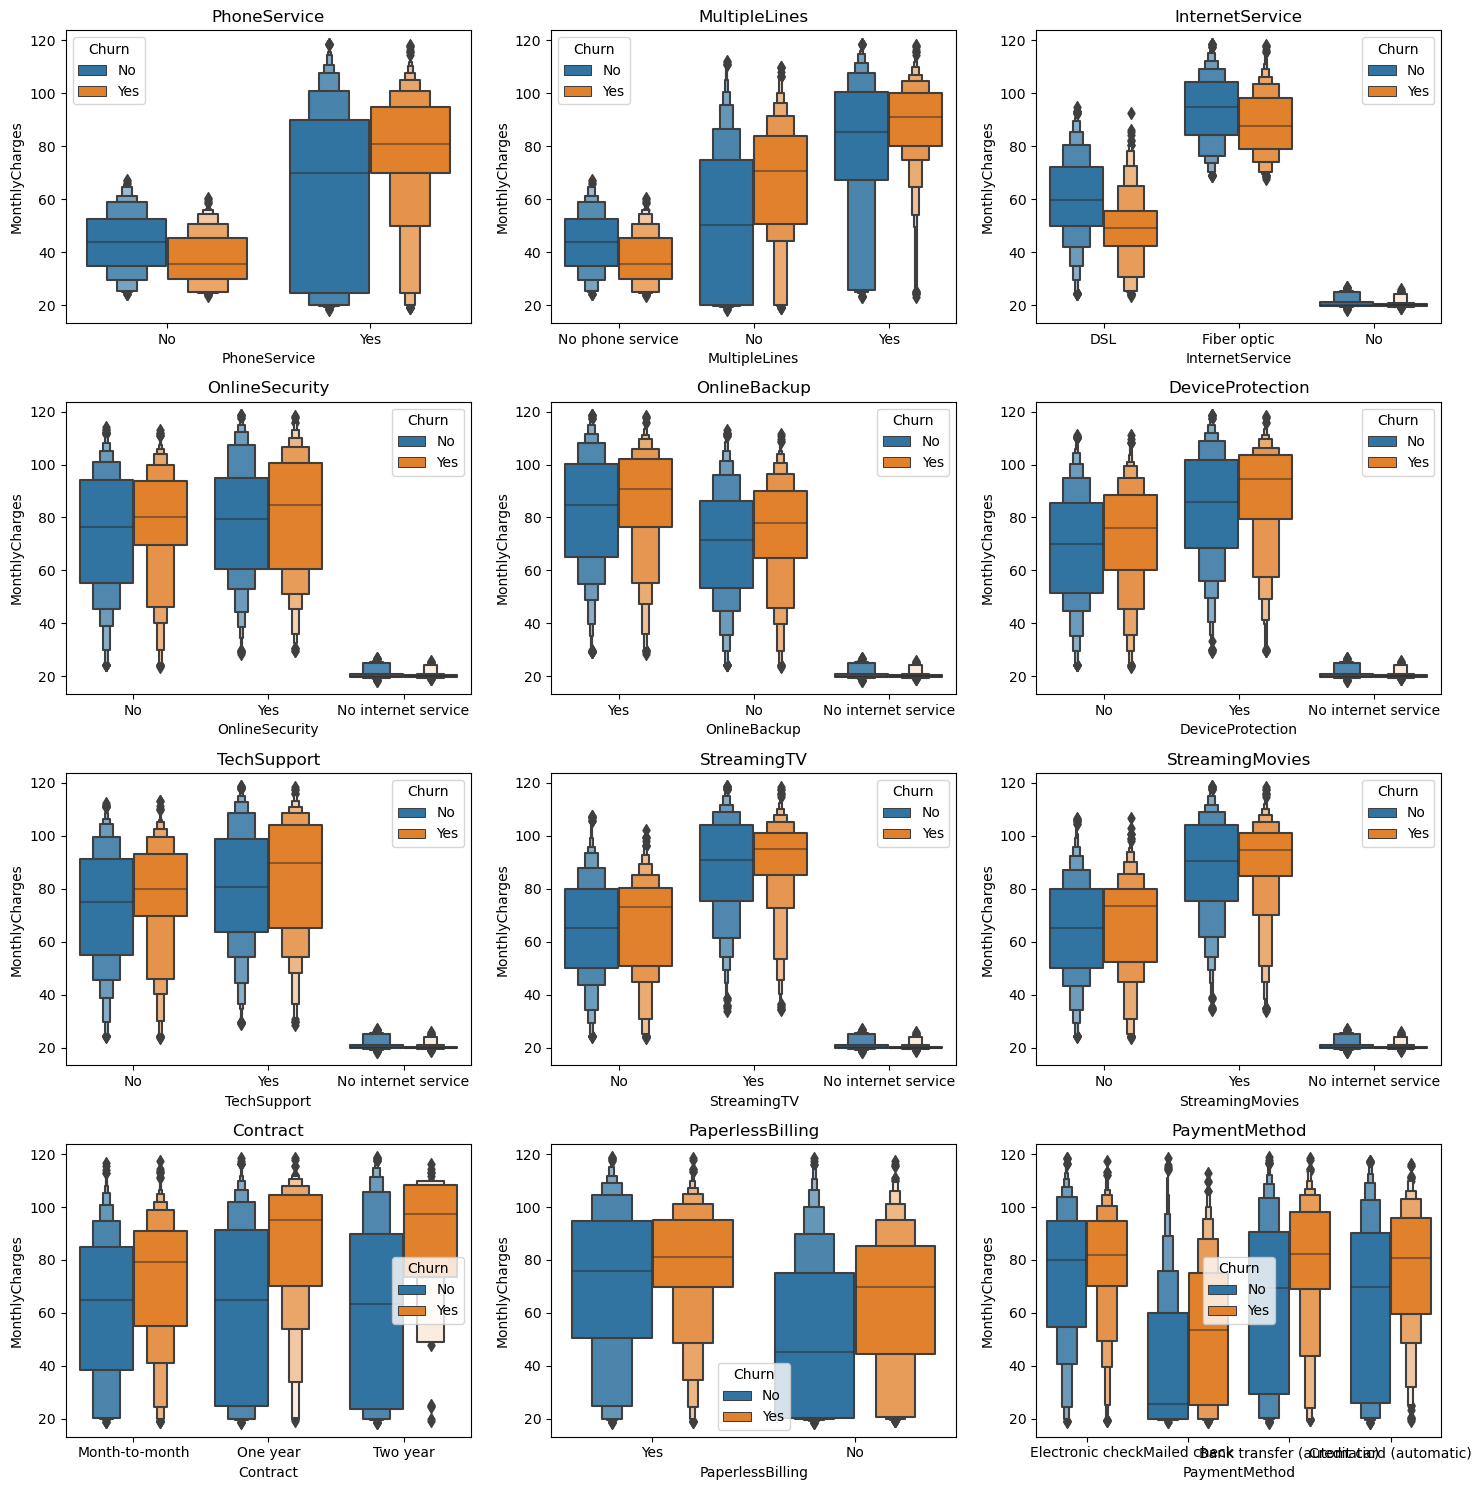

In [ ]:
def plot_charges(variables, nrow, ncol, size):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, size))
    axes = axes.flatten()
    
    for i, variable in enumerate(variables):
        ax = sns.boxenplot(data=org, x=variable, y='MonthlyCharges', hue='Churn', ax=axes[i])        
        ax.set_title(variable)

    plt.tight_layout()
    plt.show()


# plot
var_charges = var_service + var_account_cat
plot_charges(var_charges, 4, 3, 15)

## Turn imbalanced data to balanced data

In [50]:
# encode categorical data
# PS: Use label encoder when there is no order within the categorical data
category_encoder = LabelEncoder()

var_cat = var_demo + var_service + var_account_cat
for i in var_cat:
    org[i] = category_encoder.fit_transform(org[i])
    print(i,' : ',org[i].unique(),' = ', category_encoder.inverse_transform(org[i].unique()))

gender  :  [0 1]  =  ['Female' 'Male']
SeniorCitizen  :  [0 1]  =  [0 1]
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Is_MonthlyCharges_Changed  :  [0 1]  =  [0 1]


In [44]:
# sampling_strategy = 1 means over sample the minority to 100% of majority

over_sampler = SMOTE(sampling_strategy=1, random_state=0)

# seperate X and y from original dataset
X = org.copy()
y = X.pop('Churn')


